# Reducing Autocorrelation
*R.A. Collenteur, University of Graz*

In this notebook we look at two strategies that may help to reduce the autocorrelation in the noise, such that the estimated standard errors of the parameters may be used for further analysis. 

- The first strategy is to change the time interval between the groundwater level observations by removing observations. 
- The second strategy is the use of the ARMA(1,1) noise model instead of the default AR(1) noise model. 

To show the effects of these strategies we look at example models for a groundwater level time series observed near the town of Wagna in Southeastern Austria. This analysis is based on the study from [Collenteur et al. (2021)](#References). 

<div class="alert alert-warning">
<b>Note:</b>
While the groundwater level data is the same to that used for the publication, the precipitation and potential evaporation data is not the same (due to open data issues). The results from this notebook are therefore not the same as in the manuscript. 
</div>

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions(numba=True, lmfit=True)

Python version: 3.8.2 (default, Mar 25 2020, 11:22:43) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version: 1.21.2
Scipy version: 1.7.1
Pandas version: 1.3.3
Pastas version: 0.19.0b
Matplotlib version: 3.4.3
lmfit version: 1.0.2
numba version: 0.51.2


## 1. Read Data and plot autocorrelation
First we load example data from the hydrological research station Wagna in Southeastern Austria. Below is a plot of the original daily groundwater levels observations, along with a plot of the autocorrelation of the groundwater levels. The autocorrelation plot clearly shows that for the first 10 to 15 time lags the correlation between observations is very close to 1 (note the log-scale used for the x-axis). A possible interpretation may be that the additional measurements (e.g. below a 10-day interval) do not provide much additional information. This finding is quite common because many groundwater systems respond slow, resulting in smooth groundwater level time series.

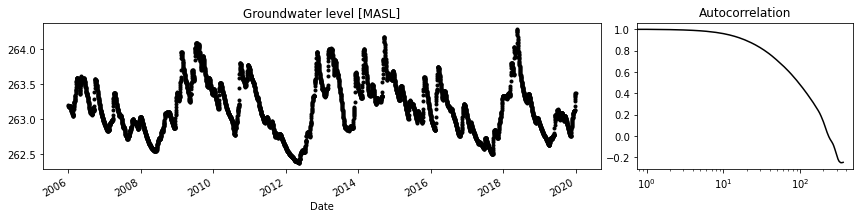

In [2]:
head = pd.read_csv("data_wagna/head_wagna.csv", index_col=0, parse_dates=True, 
                   squeeze=True, skiprows=2).loc["2006":]
evap = pd.read_csv("data_wagna/evap_wagna.csv", index_col=0, parse_dates=True, 
                   squeeze=True, skiprows=2)
rain = pd.read_csv("data_wagna/rain_wagna.csv", index_col=0, parse_dates=True, 
                   squeeze=True, skiprows=2)

ax = head.plot(figsize=(10,3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95,0.2,0.3,0.68])
ax1.semilogx(ps.stats.acf(head).values, color="k")  # Plot on log-scale
ax.set_title("Groundwater level [MASL]")
ax1.set_title("Autocorrelation");

## 2. Run models with AR(1) noise model

We now create models to simulate the groundwater levels, while increasing the interval between groundwater level observations through removal of observations. The original time series have daily observations, which is increased to one observation every 10th day here. Two types of recharge models are tested; one with a linear model and one with a nonlinear recharge model. The AR(1) model is used to try and transform the correlated residuals into approximate white noise.

In [3]:
mls_ar = {}
dts = 11

# Model settings
tmin = "2007-01-01"
tmax = "2016-12-31"
solver = ps.LmfitSolve

# The two models we compare here
config = {
    "Linear": [ps.FourParam, ps.rch.Linear()],
    "Nonlinear": [ps.Exponential, ps.rch.FlexModel()],
}

for name, [rfunc, rch] in config.items():
    for dt in range(1, dts, 2):
        # Create the basic Pastas model
        ml_name = f"{name}_{dt}"
        ml = ps.Model(head.iloc[::dt], name=ml_name)

        # Add the recharge model
        sm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=rfunc, 
                              name="rch")
        ml.add_stressmodel(sm)
        
        # Change parameter settings for non-linear recharge model
        if name == "Nonlinear":
            ml.set_parameter("rch_srmax", vary=False)
            ml.set_parameter("rch_kv", vary=True)
            ml.set_parameter("constant_d", initial=262)

        # Solve the model
        ml.solve(tmin=tmin, tmax=tmax, report=False, solver=solver, 
                 method="least_squares")
        mls_ar[ml_name] = ml

## 3. Run models with ARMA(1,1) noise model
We now repeat the previous analysis with the ARMA(1,1) model to transform the correlated residuals into approximate white noise. Note that for now this model is only applicable to time series with (approximately) regular time intervals between groundwater level observations.

In [4]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)
    
    #Change the noise model
    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaModel())

    # Solve the model
    ml.solve(tmin=tmin, tmax=tmax, report=False, solver=solver, 
             method="least_squares")
    mls_arma[ml_name] = ml

## 4. Plot and compare the the results
Let's have a look at the results for all the simulations we just did. We have two types of recharge models (linear and non-linear) and two types of noise model (AR(1) and ARMA(1,1,)). Additionally, we calibrated these models with an increasing time interval between the groundwater level observations. 

Next, we use the Durbin-Watson (DW) test and the Ljung-Box test to test if the model noise exhibits significant autocorrelation. To illustrate the effect of the different strategies we plot the computed Durbin-Watson test statistic with increasing time intervals. When there is no significant autocorrelation at the first time lag, the DW-statistic should be close to the value 2. 

The results are shown in the plot below. Three things may be concluded from this plot:

1. The autocorrelation in the noise (measured as DW) decreases when the time interval between observations is increased,
2. The use of an ARMA(1,1) noise model decreases the time lag-one autocorrelation,
3. The non-linear model seems to cause less autocorrelation in the noise.

It is noted that these results are site-specific, but this strategy can be useful to reduce the autocorrelation in the noise for other sites as well.

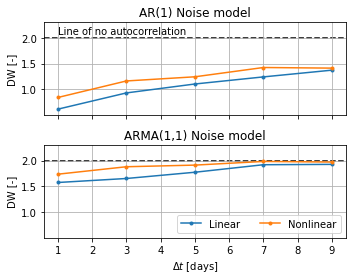

In [5]:
data = pd.DataFrame(index=range(dt, 1), columns=config.keys())

for ml in mls_ar.values():   
    name, i = ml.name.split("_")
    n = ml.noise(tmin=tmin, tmax=tmax).asfreq(f"{i}D").fillna(0.0)
    data.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

data2 = pd.DataFrame(index=range(dt, 1), columns=config.keys())

for ml in mls_arma.values():   
    name, i = ml.name.split("_")
    n = ml.noise(tmin=tmin, tmax=tmax).asfreq(f"{i}D").fillna(0.0)
    data2.loc[int(i), name] = ps.stats.durbin_watson(n)[0]

# Plot the results
fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(5, 4), sharey=True)

# AR1 Model
data.plot(ax=ax1, marker=".", legend=False)
ax1.set_ylabel("DW [-]")
ax1.axhline(2., c="k", linestyle="--", zorder=-1)
ax1.text(1, 2.07, "Line of no autocorrelation")
ax1.grid()
ax1.set_title("AR(1) Noise model")

# ArmaModel
data2.plot(ax=ax2, marker=".", legend=False)
ax2.set_ylabel("DW [-]")
ax2.set_yticks([1, 1.5, 2.])
ax2.axhline(2., c="k", linestyle="--", zorder=-10)
ax2.set_ylim(0.5, 2.3)
ax2.grid()
ax2.legend(ncol=3, loc=4)
ax2.set_xlabel("$\Delta t$ [days]")
ax2.set_title("ARMA(1,1) Noise model")
plt.tight_layout()

## 5. Consistency of parameter estimates
Based on the analysis above we may to choose to use the ARMA(1,1) noise model and a time interval of 10 days between the groundwater level observations. We could then "draw" ten groundwater level time series from the original time series and calibrate the models on each of these, as a sort of split-sample test. Below we fit both the linear and the non-linear model on ten groundwater level time series with 10-day time intervals between the observations, drawn from the original time series.

In [6]:
mls = {}
dt = 10  # Select the time interval between GWL observations

for name, [rfunc, rch] in config.items():
    for start in range(0, dt, 2):
        ml_name = f"{name}_{start+1}"
        ml = ps.Model(head.iloc[start::dt], name=ml_name)

        # Add the recharge model
        sm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=rfunc, name="rch")
        ml.add_stressmodel(sm)

        if name == "Nonlinear":
            ml.set_parameter("rch_srmax", vary=False)
            ml.set_parameter("rch_kv", vary=True)
            ml.set_parameter("constant_d", initial=262)

        # Solve the model
        ml.add_noisemodel(ps.ArmaModel())
        ml.solve(tmin=tmin, tmax=tmax, report=False, solver=solver, 
                 method="least_squares")

        mls[ml_name] = ml

In [7]:
# Extract the optimal parameters and estimated standard errors
data = {}

for name in config.keys():
    ml = mls["{}_1".format(name)]
    p = ml.parameters
    mi = pd.MultiIndex.from_product([p.index[p.vary == True].to_list(), ["opt", "std"]])
    data[name] = pd.DataFrame(index=range(dt, 1), columns=mi)

for ml in mls.values():   
    name, i = ml.name.split("_")
    df = data[name]
    for par in ml.parameters.index[ml.parameters.vary == True]:
        df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
        df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"] * 1.96

df = pd.concat(data, axis=1)

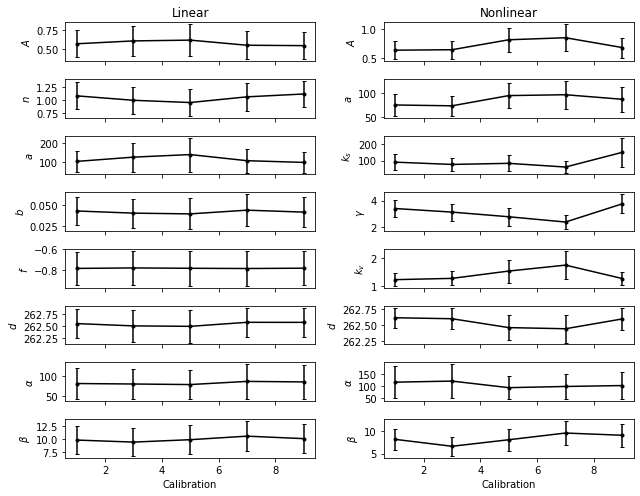

In [8]:
# Plot the results

fig, axes = plt.subplots(8,2, sharex=True, figsize=(9,7)) 
axes = axes.flatten()

kwargs = dict(legend=False, color="0", capsize=2, linestyle="-", marker=".")

labels = [["$A$", "$n$", "$a$", "$b$", "$f$", "$d$", "$\\alpha$", "$\\beta$"],
          ["$A$", "$a$", "$k_s$", "$\\gamma$", "$k_v$", "$d$", "$\\alpha$", "$\\beta$"]]

for j, rch in enumerate(["Linear", "Nonlinear"]):
    axes[j].set_title(rch)
    for i, par in enumerate(df[rch].columns.get_level_values(0).unique()):
        df.xs((rch, par), axis=1, level=[0, 1]).plot(ax=axes[i*2+j], yerr="std", **kwargs)
        axes[i*2+j].set_ylabel(labels[j][i])
    
for i in range(2):
    axes[-i-1].set_xlabel("Calibration")
    
plt.tight_layout()

The plot above shows the estimated optimal parameters and the 95% confidence intervals of the parameters. While most of the optimal parameter are relatively stable between calibrations, some parameters show larger variations. For the linear model these are, for example, $a$ and $n$, while for the non-linear model these are $k_s$ and $\gamma$. The values of these parameters seem correlated, and it might thus be difficult to estimate the individual parameter values.

## 5. Similarity of simulated heads and recharge estimates
Given the above plot, one might ask how this impacts the simulated groundwater levels and recharge. Below we plot the simulated groundwater levels for each of the models, and the estimated annual rates with two time the standard deviations. Perhaps surprisingly, the simulated groundwater levels and the estimated annual recharge rates are very similar to each other. This shows that caution is necessary when interpreting individual parameters, but the simulated time series may be useful for further analysis.

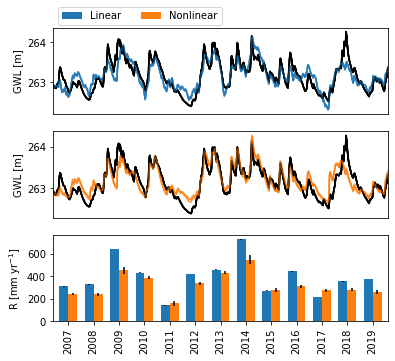

In [9]:
rch = {"Linear": pd.DataFrame(columns=range(dt, 1)),
      "Nonlinear": pd.DataFrame(columns=range(dt, 1))}

for ml in mls.values():   
    name, i = ml.name.split("_")
    rch[name].loc[:, i] = ml.get_stress("rch", tmin=tmin, 
                                        tmax="2019-12-31").resample("A").sum()

df1 = pd.concat(rch, axis=1)
df1.index = df1.index.year

fig, [ax1, ax2, ax3] = plt.subplots(3,1, figsize=(6,6))

for ml in mls.values():
    if ml.name.split("_")[0] == "Linear":
        ax = ax1
        color = "C0"
    else:
        ax = ax2
        color = "C1"
        
    ml.oseries.plot(ax=ax, linestyle="-", marker=" ", c="k")
    ml.simulate(tmax="2020").plot(ax=ax, alpha=0.5, c=color, x_compat=True)
    ax.set_xticks([])
    ax.set_ylabel("GWL [m]")
    ax.set_xlim("2007", "2020")

df1.groupby(level=0, axis=1).mean().plot.bar(yerr=1.96 * df1.groupby(level=0, axis=1).std(), ax=ax3, width=0.7)
plt.legend(ncol=3, loc=2, bbox_to_anchor=(0, 3.7))

plt.ylabel("R [mm yr$^{-1}$]")
plt.xlabel("");

## Data sources
- The groundwater level time series for the hydrological research station Wagna in Austria were obtained from the government of Styria in cooperation with [JR-AquaConsol](https://www.jr-aquaconsol.at/). We acknowledge JR-AquaConsol for providing the time series and allowing its use in this example. This data may not be redistributed without explicit permission from JR-AquaConsol.

- Precipitation and evaporation time series were obtained from the gridded E-OBS database [(Cornes et al. (2018)](#References). We acknowledge the E-OBS dataset from the EU-FP6 project UERRA (https://www.uerra.eu) and the Copernicus Climate Change Service, and the data providers in the ECA&D project (https://www.ecad.eu). 

## References

- Cornes, R., G. van der Schrier, E.J.M. van den Besselaar, and P.D. Jones. 2018: An Ensemble Version of the E-OBS Temperature and Precipitation Datasets, J. Geophys. Res. Atmos., 123. doi:10.1029/2017JD028200.
- Collenteur, R., Bakker, M., Klammler, G., and Birk, S. (2021) [Estimation of groundwater recharge from groundwater levels using nonlinear transfer function noise models and comparison to lysimeter data](https://doi.org/10.5194/hess-2020-392), Hydrol. Earth Syst. Sci., 25, 2931–2949.